In [2]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from multiparam_output_loader import MultiParamOutputLoader

# output = MultiParamOutputLoader("/nfs01/covid_sims/1591720627.0466504-test_protocol_QFNR/")
# need to specify the following line by your own path
output = MultiParamOutputLoader(module_path + "/src/simulations_v2/sim_output/1595461358-multiparam/")

/Users/stevewangen/projects/COVID/uw_reopening/src/simulations_v2/multiparam_output_loader.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  param_specifier = yaml.load(f)


In [3]:
output.param_scenarios

['Nominal Parameters']

In [4]:
output.sim_results['Nominal Parameters'][(0.000274, 0.008928571429)][0]

,S,QS,QI,R,E_0,E_1,E_2,E_3,E_4,E_5,...,SyID_severe_17,SyID_severe_18,SyID_severe_19,cumulative_mild,cumulative_severe,cumulative_outside_infections,severity_0,severity_1,severity_2,severity_3
0,7997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.000000,0.000000,0.000000
1,7995,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,2,0.0,0.000000,0.000000,0.000000
2,7993,0,0,0,1,0,2,0,0,0,...,0,0,0,0,1,4,0.0,0.975404,0.018016,0.006580
3,7987,1,0,0,2,2,0,1,2,0,...,0,0,0,2,1,7,2.0,0.975404,0.018016,0.006580
4,7982,1,0,0,3,2,2,3,0,0,...,0,0,0,3,1,9,3.0,0.975404,0.018016,0.006580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2529,38,461,4913,5,0,1,0,0,0,...,0,0,0,2613,2801,92,2613.0,2732.106993,50.462291,18.430717
109,2523,42,435,4949,1,0,0,0,0,0,...,1,0,0,2617,2803,92,2617.0,2734.057801,50.498322,18.443877
110,2531,32,421,4968,0,0,0,1,1,0,...,0,0,0,2619,2808,93,2619.0,2738.934822,50.588401,18.476777
111,2524,35,401,4993,1,2,1,1,0,0,...,0,0,0,2623,2808,93,2623.0,2738.934822,50.588401,18.476777


In [5]:
from deprecated.params import ParamConfig

# Massey's suggestion (but syntax looks different)
# from load_params import load_params

base_params = ParamConfig.load_config('fall', True, 'nominal')
params = base_params.copy()

In [6]:
cumulative_cols = ['QI','R'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
recovered_cols = ['R']
active_cols = ['QI'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
free_infectious = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]

In [7]:
import numpy as np
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, get_active_infection_cols, get_pop_size,\
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips, \
                            load_sim_dir

In [11]:
def plot_fig1(data, int_pre, day):
    #plt.figure(figsize=(15,9))
    #sample = dfsoutput.sim_results['Nominal Parameters'][][0]
    sample = data
    plt.ylim(0, 6000)
    plt.plot(sample[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
    plt.plot(sample[recovered_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='red')
    plt.plot(sample[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
    plt.plot(sample[free_infectious].sum(axis=1), linewidth=2.5, alpha=0.5, color='green')
    plt.xlabel("Day", size=14)
    plt.ylabel("Number of Active Infections", size=14)
    #plt.title('Simulated COVID Progression under Nominal Parameters\n ({}%initial prevalence, {}-day testing)'.format(round(100 * int_pre, 3), day), size=18)
    plt.title('({}%initial prevalence, {}-day testing)'.format(round(100 * int_pre, 3), day), size=10)
    plt.legend(('Cumulative people with COVID', 'Recovered', 'Active', 'Free Infectious'), loc='best')
#sample_high

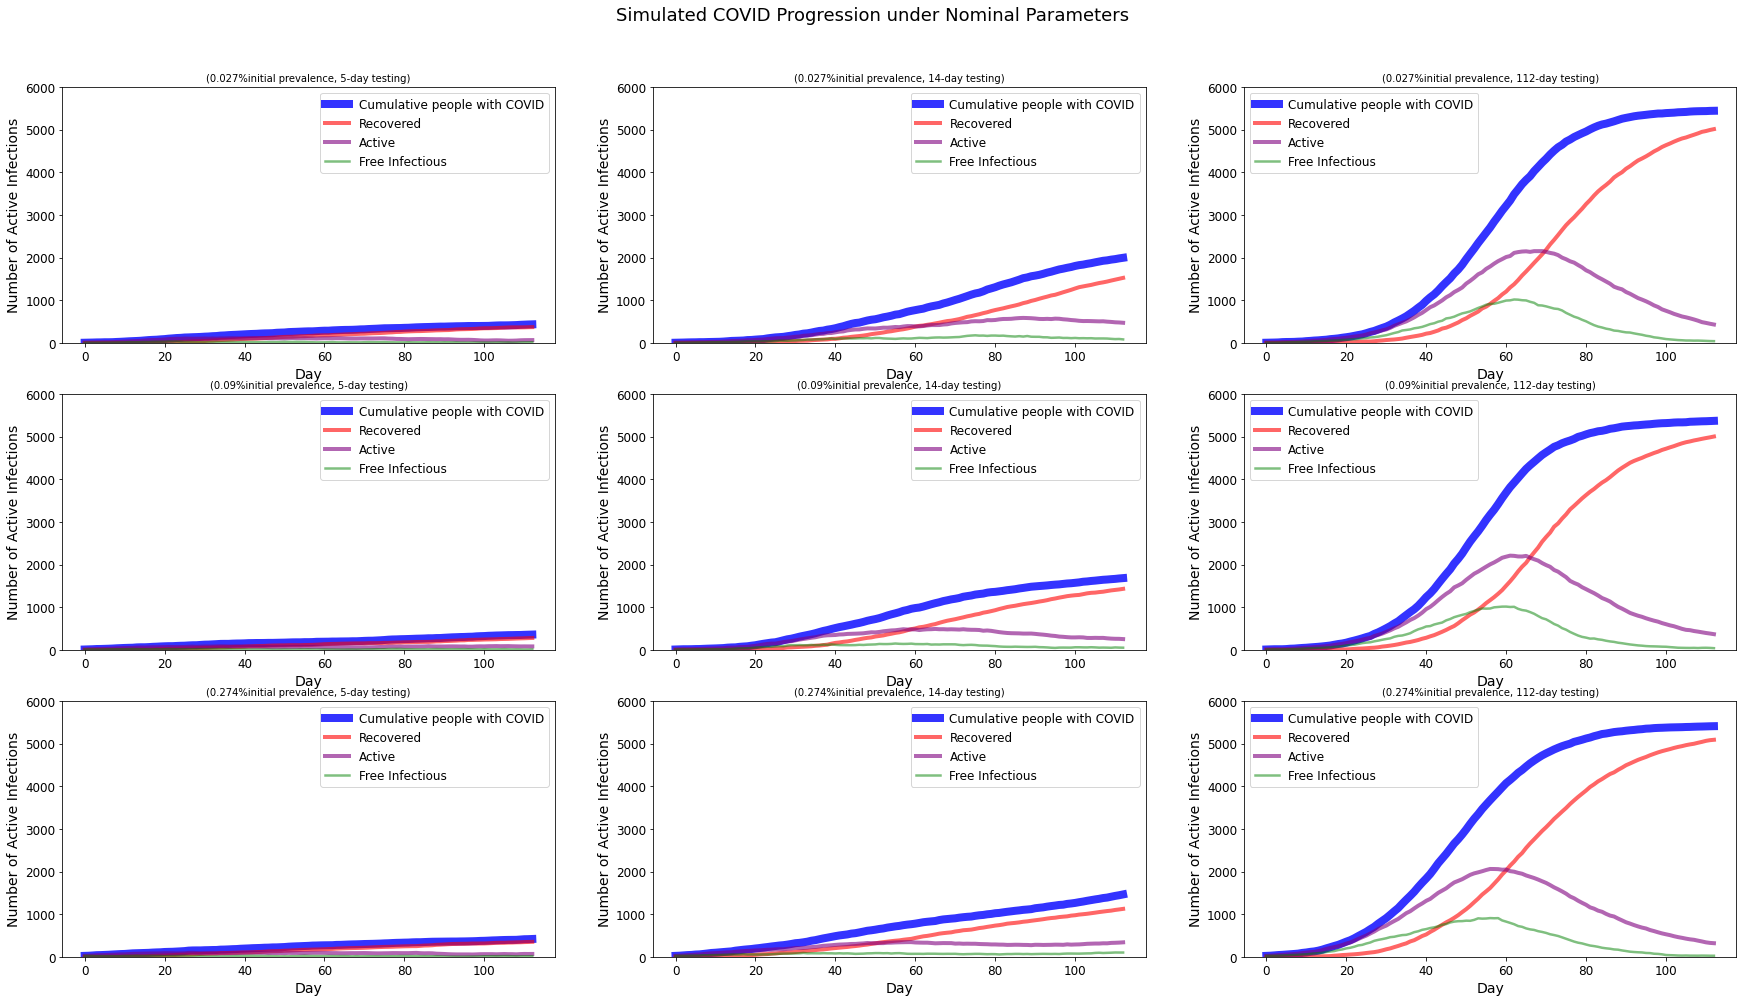

In [12]:
initial_ID_pre_val = [0.000274, 0.0009, 0.00274]
test_popu_frac_val = [0.2, 0.07142857143, 0.008928571429]
test_day = [5, 14, 112]

dfs=output.sim_results['Nominal Parameters']

fig = plt.figure(figsize=(30,16))
fig.suptitle('Simulated COVID Progression under Nominal Parameters', size=18, y = 0.95)
fig_count = 0
for j in range(len(initial_ID_pre_val)):
    for i in range(len(test_popu_frac_val)):
        fig_count = fig_count + 1
        plt.subplot(3, 3, fig_count)
        plot_fig1(dfs[(initial_ID_pre_val[j], test_popu_frac_val[i])][0], initial_ID_pre_val[j], test_day[i])